<a href="https://colab.research.google.com/github/ccrisan7/TrafficSignRecognitionSystem/blob/main/SI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#</b>Sistem automat de procesare de imagini pentru recunoașterea semnelor de circulație</b></h1>


Se definește o serie de transformări care vor fi aplicate imaginilor din setul de date pentru preprocesare, inclusiv redimensionare, rotire aleatoare și flip orizontal. În cele din urmă, se încarcă setul de date GTSRB (German Traffic Sign Recognition Benchmark) cu transformările definite, pentru a fi utilizat în antrenarea sau testarea unui model de recunoaștere a semnelor de circulație.


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = datasets.GTSRB(root='./data', split='train', transform=transform, download=True)

100%|██████████| 187490228/187490228 [00:08<00:00, 21535837.51it/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


Se definește apoi o listă care conține clasele de semne de circulație pe care dorim să le păstrăm. Urmează definirea unui dicționar care mapează codurile claselor la descrierile lor. Odată ce datele sunt pregătite, este generat un tabel și salvat ca imagine PNG.


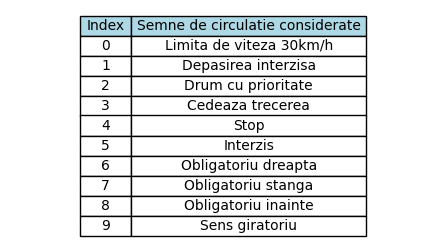

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

classes_to_keep = [1, 9, 12, 13, 14, 17, 33, 34, 35, 40]

classes = {
    1: "Limita de viteza 30km/h",
    9: "Depasirea interzisa",
    12: "Drum cu prioritate",
    13: "Cedeaza trecerea",
    14: "Stop",
    17: "Interzis",
    33: "Obligatoriu dreapta",
    34: "Obligatoriu stanga",
    35: "Obligatoriu inainte",
    40: "Sens giratoriu"
}

df = pd.DataFrame(list(classes.values()), columns=["Semne de circulatie considerate"])

df['Index'] = range(len(df))

df = df[['Index', 'Semne de circulatie considerate']]

fig, ax = plt.subplots(figsize=(5.5, 3))
ax.axis('tight')
ax.axis('off')

column_widths = [0.1, 0.46]

table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 cellLoc='center',
                 colColours=['lightblue']*len(df.columns),
                 loc='center',
                 colWidths=column_widths)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

ax.get_xaxis().set_visible(False)

plt.savefig('semne_de_circulatie.png', bbox_inches='tight', pad_inches=0.1)

plt.show()

Se filtrează un set de date de imagini și label-uri, selectând doar acele exemple care sunt asociate cu clasele specificate. Apoi, transformă aceste date filtrate într-un format potrivit pentru utilizarea lor în biblioteca PyTorch pentru învățare automată. În cele din urmă, împarte setul de date în două subseturi pentru antrenare și testare și afișează numărul de imagini din fiecare subset.

In [3]:
def filter_dataset(dataset, classes):
    filtered_data = []
    filtered_labels = []
    for image, label in dataset:
        if label in classes:
            filtered_data.append(image)
            filtered_labels.append(label)
    return (filtered_data, filtered_labels)

full_dataset = [(image, label) for image, label in full_dataset]
filtered_dataset = filter_dataset(full_dataset, classes)

filtered_data_tensor = torch.stack([torch.tensor(image) for image in filtered_dataset[0]])
filtered_label_tensor = torch.tensor(filtered_dataset[1])
filtered_dataset = torch.utils.data.TensorDataset(filtered_data_tensor, filtered_label_tensor)


train_size = int(0.8 * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size
train_dataset, test_dataset = random_split(filtered_dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_train_images = len(train_loader.dataset)

num_test_images = len(test_loader.dataset)

print("Numar de imagini in setul de date de antrenare:", num_train_images)
print("Numar de imagini in setul de date de test:", num_test_images)

<ipython-input-3-d7332619dc25>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filtered_data_tensor = torch.stack([torch.tensor(image) for image in filtered_dataset[0]])


Numar de imagini in setul de date de antrenare: 6768
Numar de imagini in setul de date de test: 1692


Afisarea imaginilor pentru a verifica setul de date:

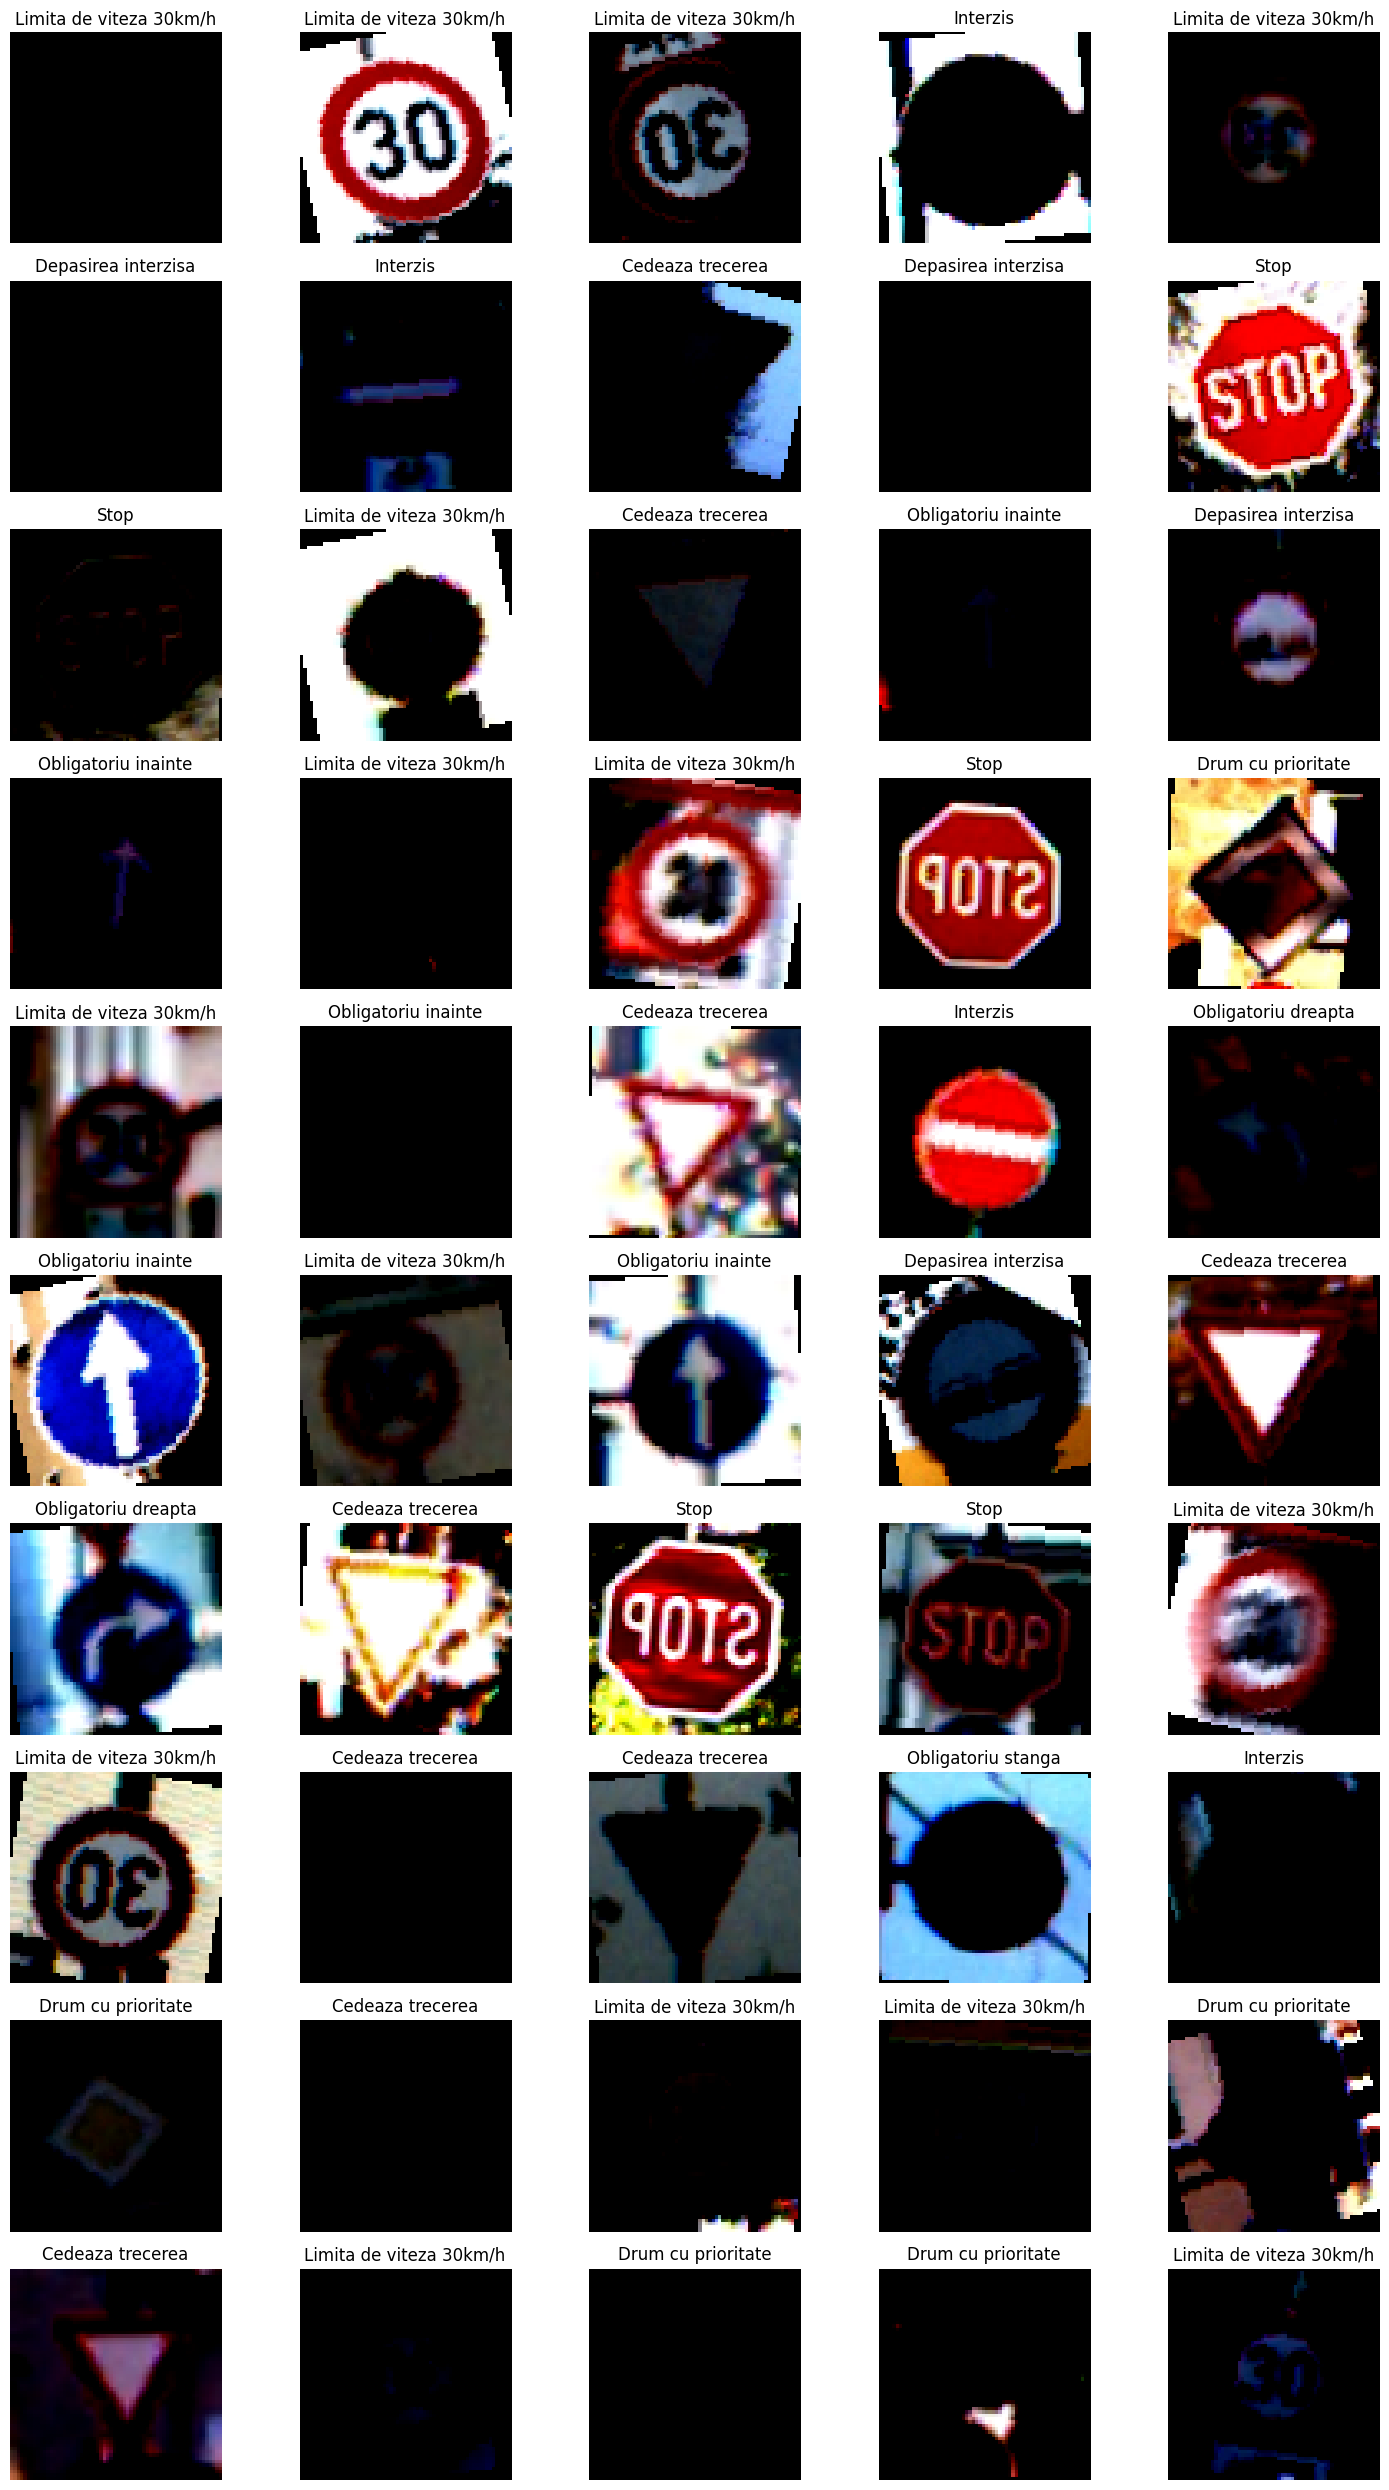

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

num_images = 50
count = 0
rows = 10
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 25))

for images, labels in train_loader:
    for i in range(len(images)):
        if count >= num_images:
            break
        label_item = labels[i].item()
        if label_item in classes:
            ax = axes[count // cols, count % cols]
            ax.set_title(classes[label_item])
            ax.imshow(np.transpose(images[i], (1, 2, 0)))
            ax.axis('off')
            count += 1

plt.tight_layout()
plt.show()

Clasa Net e o rețea neuronala convoluțională cu două straturi convoluționale și două straturi complet conectate. În constructorul clasei, se definesc toate straturile necesare pentru rețea, precum și operațiunile de inițializare a parametrilor acestor straturi folosind metoda Xavier. Metoda forward specifică modul în care datele trec prin rețea, aplicând funcții de activare, straturi de normalizare și straturi de dropout.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 43)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)

        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0.1)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0.1)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.1)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch_norm1(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = self.batch_norm2(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = Net()

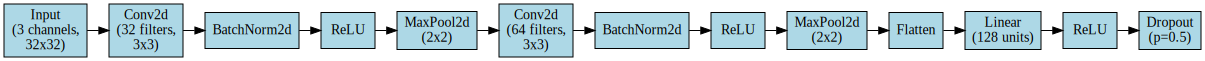

In [6]:
import graphviz

layers = [
    ("Input\n(3 channels,\n32x32)", "Conv2d\n(32 filters,\n3x3)", "input"),
    ("Conv2d\n(32 filters,\n3x3)", "BatchNorm2d", "conv1"),
    ("BatchNorm2d", "ReLU", "batch_norm1"),
    ("ReLU", "MaxPool2d\n(2x2)", "relu1"),
    ("MaxPool2d\n(2x2)", "Conv2d\n(64 filters,\n3x3)", "max_pool1"),
    ("Conv2d\n(64 filters,\n3x3)", "BatchNorm2d", "conv2"),
    ("BatchNorm2d", "ReLU", "batch_norm2"),
    ("ReLU", "MaxPool2d\n(2x2)", "relu2"),
    ("MaxPool2d\n(2x2)", "Flatten", "max_pool2"),
    ("Flatten", "Linear\n(128 units)", "flatten"),
    ("Linear\n(128 units)", "ReLU", "linear1"),
    ("ReLU", "Dropout\n(p=0.5)", "relu3"),
    ("Dropout\n(p=0.5)", "Linear\n(43 units)", "dropout"),
]

dot = graphviz.Digraph(graph_attr={'rankdir': 'LR'})

for layer in layers:
    dot.node(layer[2], layer[0], shape='box', style='filled', fillcolor='lightblue')

for i in range(len(layers) - 1):
    dot.edge(layers[i][2], layers[i + 1][2])

dot.attr(nodesep='0.1', ranksep='0.3')
dot.render('network_graph', format='png', cleanup=True)
dot

Modelul este antrenat pentru 10 epoci, iar la fiecare epocă, se calculează pierderea și se actualizează parametrii modelului cu optimizatorul. Performanța este evaluată pe seturile de date de antrenare și testare și este afișată la ieșire.

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

def calculate_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

train_accuracy_list = []
test_accuracy_list = []

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_description(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}')

    train_accuracy = calculate_accuracy(train_loader)
    print('Epoch %d, Training Accuracy: %.2f%%' % (epoch + 1, train_accuracy))
    train_accuracy_list.append(train_accuracy)

    test_accuracy = calculate_accuracy(test_loader)
    print('Epoch %d, Test Accuracy: %.2f%%' % (epoch + 1, test_accuracy))
    test_accuracy_list.append(test_accuracy)

    scheduler.step(running_loss)

print('Finished Training')

plt.plot(range(1, epochs + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'road_signs_model.pth')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [1/10], Loss: 0.9739: 100%|██████████| 212/212 [00:47<00:00,  4.50it/s]


Epoch 1, Training Accuracy: 90.48%
Epoch 1, Test Accuracy: 89.95%


Epoch [2/10], Loss: 0.3262: 100%|██████████| 212/212 [00:51<00:00,  4.08it/s]


Epoch 2, Training Accuracy: 91.52%
Epoch 2, Test Accuracy: 90.84%


Epoch [3/10], Loss: 0.1333:  62%|██████▏   | 132/212 [00:32<00:18,  4.35it/s]

Afisarea catorva teste pentru verificare si vizualizare a rezultatelor modeulului:

In [ ]:
import numpy as np

def display_images_predictions(loader, num_images=25):
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(5, 5, figsize=(20, 20))
        fig.subplots_adjust(hspace=0.5, wspace=0.5)
        for ax in axes.flatten():
            ax.axis('off')
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for j in range(min(images.size(0), 5)):
                if num_images == 0:
                    break
                ax = axes[i, j]
                image = np.transpose(images[j].cpu().numpy(), (1, 2, 0))
                image = (image - image.min()) / (image.max() - image.min())
                ax.imshow(image)
                true_label_str = classes[labels[j].item()]
                predicted_label_str = classes[predicted[j].item()]
                ax.set_title(f'True: {true_label_str}\nPredicted: {predicted_label_str}')
                num_images -= 1
                if num_images == 0:
                    break
            if num_images == 0:
                break
    plt.show()

display_images_predictions(test_loader, num_images=25)